In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import sys
import os

# --- 1. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# --- 2. Load Raw Data for EDA and Mean/Std Calculation ---
# Use transform=transforms.ToTensor() to get values in [0, 1] range for calculation
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

full_dataset_raw = datasets.MNIST(root='./data', train=True, download=True, transform=transform_to_tensor)
test_dataset_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_to_tensor)

In [5]:
# --- 3. Exploratory Data Analysis (EDA) ---
print("\n--- EDA: Data Structure and Class Distribution ---")
print(f"Total Training Samples (Raw): {len(full_dataset_raw)}")
print(f"Raw Image Tensor Shape: {full_dataset_raw.data.shape}")


--- EDA: Data Structure and Class Distribution ---
Total Training Samples (Raw): 60000
Raw Image Tensor Shape: torch.Size([60000, 28, 28])



Class Distribution (Raw Training Data):
        Count
Digit       
0       5923
1       6742
2       5958
3       6131
4       5842
5       5421
6       5918
7       6265
8       5851
9       5949


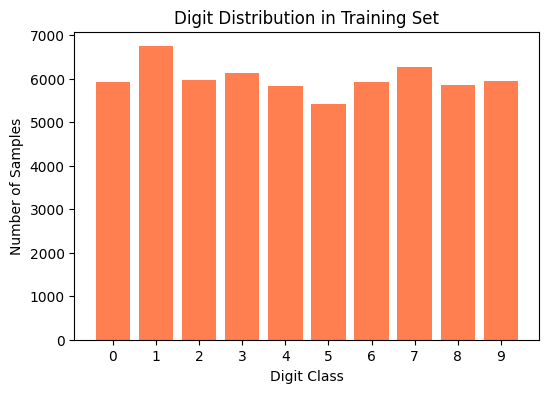

In [6]:
# 3.1 Class Distribution
labels = [label for _, label in full_dataset_raw]
label_counts = Counter(labels)
label_df = pd.DataFrame(
    {'Digit': label_counts.keys(), 'Count': label_counts.values()}
).sort_values(by='Digit').set_index('Digit')

print("\nClass Distribution (Raw Training Data):\n", label_df)

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(label_df.index.astype(str), label_df['Count'], color='coral')
plt.title('Digit Distribution in Training Set')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.show()


Class Distribution (Raw Training Data):
        Count
Digit       
0        980
1       1135
2       1032
3       1010
4        982
5        892
6        958
7       1028
8        974
9       1009


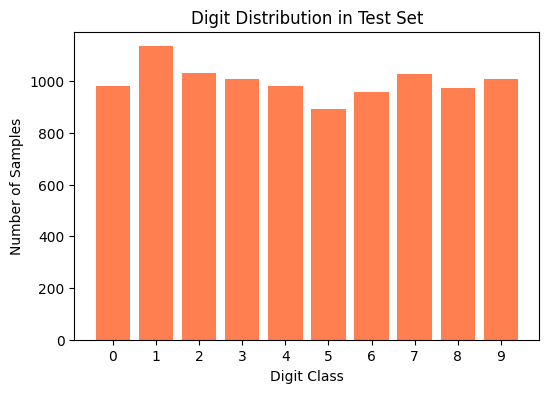

In [7]:
# 3.1 Class Distribution
labels = [label for _, label in test_dataset_raw]
label_counts = Counter(labels)
label_df = pd.DataFrame(
    {'Digit': label_counts.keys(), 'Count': label_counts.values()}
).sort_values(by='Digit').set_index('Digit')

print("\nClass Distribution (Raw Training Data):\n", label_df)

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(label_df.index.astype(str), label_df['Count'], color='coral')
plt.title('Digit Distribution in Test Set')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.show()

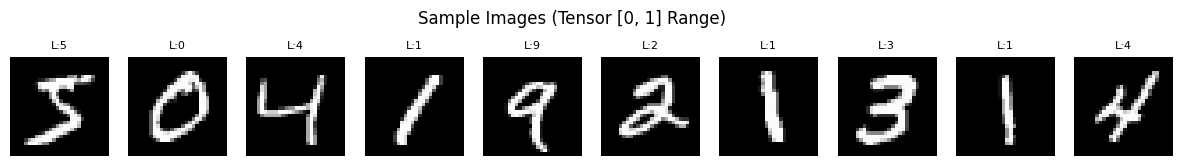

In [8]:
# 3.2 Sample Visualization
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
axes = axes.flatten()
for i in range(10):
    image_data, label = full_dataset_raw[i]
    # Squeeze to remove channel dim for imshow (1, 28, 28) -> (28, 28)
    axes[i].imshow(image_data.squeeze().cpu().numpy(), cmap='gray') 
    axes[i].set_title(f"L:{label}", fontsize=8)
    axes[i].axis('off')
plt.suptitle("Sample Images (Tensor [0, 1] Range)")
plt.show()

In [9]:
image_data.squeeze().cpu().numpy()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [10]:
# --- 4. Calculate Mean and Standard Deviation ---
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    channels_sum, channels_squared_sum, num_batches = 0.0, 0.0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

# Calculate stats using the raw training dataset (which has only ToTensor applied)
mean, std = calculate_mean_std(full_dataset_raw)

print("\n--- Normalization Statistics ---")
print(f"Calculated Mean for Normalization: {mean.tolist()}")
print(f"Calculated Std for Normalization: {std.tolist()}")


--- Normalization Statistics ---
Calculated Mean for Normalization: [0.13065215945243835]
Calculated Std for Normalization: [0.30809691548347473]


In [11]:
# --- 5. Define Final Transforms and Loaders ---
# Apply the calculated normalization
final_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Reload datasets with the FINAL transform
full_train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=final_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=final_transform)

In [12]:
# Split the 60,000 training samples into Train (50,000) and Validation (10,000)
train_size = 50000
val_size = 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [13]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 20

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# --- 6. Define Model, Optimizer, and Criterion ---
class ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.reshape(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ANN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# --- 7. Training and Validation Functions ---
def train_one_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(train_loader.dataset)

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item() * data.size(0) 
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return avg_val_loss, accuracy

In [15]:
# --- 8. Main Training Loop and Loss Tracking ---
train_losses = []
val_losses = []

print("\n--- Starting Training ---")
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch:02d}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')

print("Training complete.")


--- Starting Training ---
Epoch 01/20: Train Loss: 0.2261 | Val Loss: 0.1422 | Val Acc: 95.69%
Epoch 02/20: Train Loss: 0.0901 | Val Loss: 0.1022 | Val Acc: 97.14%
Epoch 03/20: Train Loss: 0.0626 | Val Loss: 0.1049 | Val Acc: 96.85%
Epoch 04/20: Train Loss: 0.0447 | Val Loss: 0.1116 | Val Acc: 96.99%
Epoch 05/20: Train Loss: 0.0347 | Val Loss: 0.1106 | Val Acc: 97.20%
Epoch 06/20: Train Loss: 0.0305 | Val Loss: 0.1092 | Val Acc: 97.34%
Epoch 07/20: Train Loss: 0.0267 | Val Loss: 0.0999 | Val Acc: 97.56%
Epoch 08/20: Train Loss: 0.0234 | Val Loss: 0.1040 | Val Acc: 97.51%
Epoch 09/20: Train Loss: 0.0216 | Val Loss: 0.1295 | Val Acc: 97.22%
Epoch 10/20: Train Loss: 0.0204 | Val Loss: 0.1101 | Val Acc: 97.52%
Epoch 11/20: Train Loss: 0.0176 | Val Loss: 0.1154 | Val Acc: 97.59%
Epoch 12/20: Train Loss: 0.0171 | Val Loss: 0.1108 | Val Acc: 97.82%
Epoch 13/20: Train Loss: 0.0159 | Val Loss: 0.1167 | Val Acc: 97.73%
Epoch 14/20: Train Loss: 0.0122 | Val Loss: 0.1140 | Val Acc: 97.72%
Epoch 1


--- Final Test Set Results ---
Test Loss: 0.1265, Test Accuracy: 97.77%


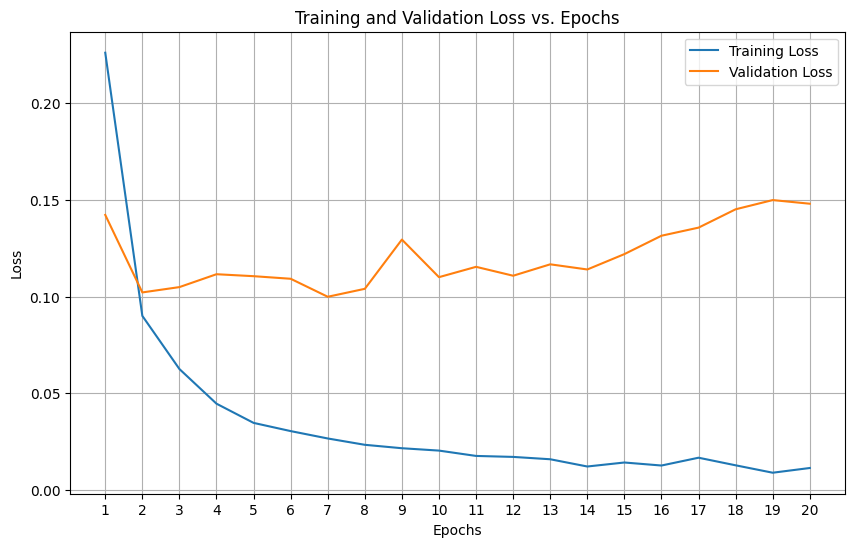

In [16]:
# --- 9. Final Evaluation on Test Set ---
test_loss, test_acc = validate(model, device, test_loader, criterion)
print(f'\n--- Final Test Set Results ---')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


# --- 10. Plotting the Loss Curve ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, num_epochs + 1, 1))
plt.legend()
plt.grid(True)
plt.show()

# Suppress plot output if running in a non-interactive environment
try:
    plt.close()
except:
    pass

1. Initial Phase (Epochs 1-3): Rapid Learning

Training Loss (Blue Line): Decreases very sharply from Epoch 1 to 3. This indicates that model is learning the training data patterns very quickly and effectively.

Validation Loss (Orange Line): Also decreases sharply from Epoch 1 to 2, before starting to level off. This shows the initial learning generalizes well to unseen data.

2. Optimal Region (Epochs 4-7): Best Generalization

Training Loss: Continues to decrease steadily, meaning the model is still fitting the training data better.

Validation Loss: Flattens out and stays low, hovering around 0.10 to 0.11.

Interpretation: The gap between the two curves is small, and the validation loss is relatively stable. This period represents the sweet spot where model has achieved good performance without significantly overfitting. Epoch 6 or 7 would likely be the best time to stop training to get the best performance on a completely new test set.


3. Overfitting Begins (Epochs 8-20): Divergence

Training Loss: Continues its steady descent, dropping very close to zero (below 0.01 by Epoch 20). This means the model is memorizing the specific details and noise of the training data.

Validation Loss: This is the clear indicator of overfitting.

It starts to become volatile (the spike around Epoch 9).

Crucially, after Epoch 13 or 14, it begins a clear, sustained increase, rising from around 0.11 to nearly 0.15 by Epoch 20.

Interpretation (Overfitting): The model's performance on the unseen validation data is actively getting worse, even as its performance on the training data improves. The model is sacrificing generalization ability for perfection on the training set.


**Conclusion and Actionable Advice**

Stop Training Earlier: The model is significantly overfit by the end of 20 epochs. We should implement an Early Stopping mechanism based on the validation loss. The best model checkpoint to save would be from the epoch where the validation loss was at its minimum (around Epoch 6 or 7).

Mitigation: If training for more epochs, i can regularization techniques to shrink the gap between the two curves and prevent the validation loss from rising:

Dropout: Add nn.Dropout() layers to ANN model.

L2 Regularization (Weight Decay): Increase the weight_decay parameter in optim.Adam call




**Conclusion: Use Both**

The best approach is to use them in combination:

Use Regularization (L2/Dropout): This is primary method for combatting overfitting. It makes the model inherently simpler, forcing it to find generalized solutions rather than memorizing noise. This widens the optimal training window where the validation loss remains low.

Use Early Stopping: This is secondary method and efficiency tool. It ensures to stop training precisely when the model starts to overfit (when the validation loss stops improving) and prevents wasting computation time on epochs that only increase the val loss

**Why Regularization is Needed even with Early Stopping:**

If we rely only on Early Stopping without regularization, model might be so complex that it achieves a very low training loss but its minimum validation loss (the point where we stop) is still quite high.

By using regularization,we can:

Achieve a lower minimum validation loss (better final model accuracy).

Have a more stable training process where the validation curve doesn't spike sharply, giving the optimizer more time to fine-tune weights.




### Dropout_WeightDecay

In [16]:
class Dropout_ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Dropout_ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.dropout1 = nn.Dropout(0.5) # Example: Add Dropout after ReLU
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.2) # Add a second Dropout layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.reshape(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x) # Apply dropout
        x = self.fc3(x)
        return x

In [17]:
model = Dropout_ANN(input_size, num_classes).to(device)
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [22]:
# --- 8. Main Training Loop and Loss Tracking ---
train_losses = []
val_losses = []

print("\n--- Starting Training ---")
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch:02d}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')

print("Training complete.")


--- Starting Training ---
Epoch 01/20: Train Loss: 0.3343 | Val Loss: 0.1557 | Val Acc: 95.29%
Epoch 02/20: Train Loss: 0.1768 | Val Loss: 0.1422 | Val Acc: 95.86%
Epoch 03/20: Train Loss: 0.1463 | Val Loss: 0.1084 | Val Acc: 96.76%
Epoch 04/20: Train Loss: 0.1266 | Val Loss: 0.1037 | Val Acc: 96.92%
Epoch 05/20: Train Loss: 0.1192 | Val Loss: 0.0948 | Val Acc: 97.35%
Epoch 06/20: Train Loss: 0.1109 | Val Loss: 0.0956 | Val Acc: 97.28%
Epoch 07/20: Train Loss: 0.1049 | Val Loss: 0.0957 | Val Acc: 97.17%
Epoch 08/20: Train Loss: 0.0988 | Val Loss: 0.0969 | Val Acc: 97.36%
Epoch 09/20: Train Loss: 0.0971 | Val Loss: 0.0957 | Val Acc: 97.38%
Epoch 10/20: Train Loss: 0.0960 | Val Loss: 0.0850 | Val Acc: 97.66%
Epoch 11/20: Train Loss: 0.0875 | Val Loss: 0.0848 | Val Acc: 97.60%
Epoch 12/20: Train Loss: 0.0916 | Val Loss: 0.0909 | Val Acc: 97.49%
Epoch 13/20: Train Loss: 0.0887 | Val Loss: 0.0872 | Val Acc: 97.52%
Epoch 14/20: Train Loss: 0.0872 | Val Loss: 0.0866 | Val Acc: 97.64%
Epoch 1


--- Final Test Set Results ---
Test Loss: 0.0699, Test Accuracy: 97.85%


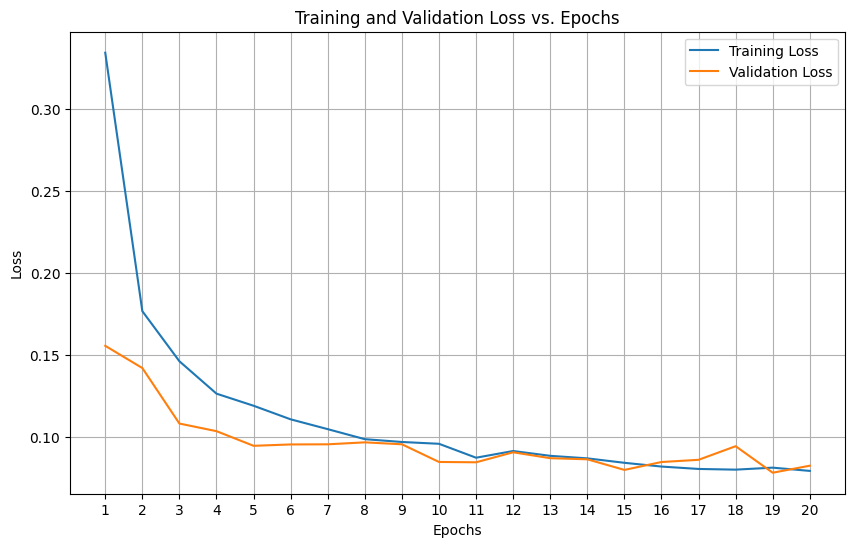

In [23]:
# --- 9. Final Evaluation on Test Set ---
test_loss, test_acc = validate(model, device, test_loader, criterion)
print(f'\n--- Final Test Set Results ---')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


# --- 10. Plotting the Loss Curve ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, num_epochs + 1, 1))
plt.legend()
plt.grid(True)
plt.show()

# Suppress plot output if running in a non-interactive environment
try:
    plt.close()
except:
    pass

1. Epoch 1-4 : Rapid Learning: The model is finding core patterns. Generalization is excellent, as the validation loss drops quickly.
2. Epoch 5-10: Initial Fit: Training loss continues to improve, but validation loss is flat. The model is now starting to find details specific to the training set, increasing the gap slightly
3. Epoch 11-17: Near Optimal: The regularization is working well! Unlike the previous graph where validation loss increased, here it remains low and actually finds a slightly lower minimum. This is the most robust part of the training.
4. Epoch 18-20: Slight Overfit/Noise: The validation loss fluctuates and seems to settle at a slightly higher level than the minimum. The model is starting to overfit, or the optimizer is simply bouncing around the optimum.

### Dropout + WeightDecay + EarlyStopping

In [20]:
# Define the Early Stopping class
class EarlyStopping:
    """
    Stops training when the validation loss hasn't improved after a given patience.
    Saves the best model found so far.
    """
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint_best_model.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            path (str): Path for the checkpoint to save the best model.
                            Default: 'checkpoint_best_model.pt'
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss # We want to maximize the score (minimize loss)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            # Loss did not improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Loss improved
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        
        # Save only the model state dictionary
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [21]:
model = Dropout_ANN(input_size, num_classes).to(device)
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Hyperparameters
num_epochs = 100 # Set a high number of epochs, let Early Stopping decide when to stop

# --- Initialize Early Stopping ---
# We use patience=7 to wait for 7 epochs of no improvement before stopping
early_stopping = EarlyStopping(patience=7, verbose=True) 


# --- Main Loop with Early Stopping ---
train_losses = []
val_losses = []

print("\n--- Starting Training with Early Stopping ---")
for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss = train_one_epoch(model, device, train_loader, optimizer, criterion)
    
    # Validation step
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print epoch summary
    print(f'Epoch {epoch:02d}: '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')

    # CHECK EARLY STOPPING CONDITION
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print(f"Early stopping triggered at Epoch {epoch}!")
        break

print("Training finished.")


--- Starting Training with Early Stopping ---
Epoch 01: Train Loss: 0.3290 | Val Loss: 0.1507 | Val Acc: 95.52%
Validation loss decreased (inf --> 0.150731). Saving model...
Epoch 02: Train Loss: 0.1772 | Val Loss: 0.1254 | Val Acc: 96.17%
Validation loss decreased (0.150731 --> 0.125355). Saving model...
Epoch 03: Train Loss: 0.1467 | Val Loss: 0.1042 | Val Acc: 96.90%
Validation loss decreased (0.125355 --> 0.104206). Saving model...
Epoch 04: Train Loss: 0.1325 | Val Loss: 0.0977 | Val Acc: 97.09%
Validation loss decreased (0.104206 --> 0.097673). Saving model...
Epoch 05: Train Loss: 0.1167 | Val Loss: 0.1047 | Val Acc: 96.85%
EarlyStopping counter: 1 out of 7
Epoch 06: Train Loss: 0.1109 | Val Loss: 0.0882 | Val Acc: 97.28%
Validation loss decreased (0.097673 --> 0.088239). Saving model...
Epoch 07: Train Loss: 0.1071 | Val Loss: 0.0828 | Val Acc: 97.39%
Validation loss decreased (0.088239 --> 0.082836). Saving model...
Epoch 08: Train Loss: 0.0980 | Val Loss: 0.0810 | Val Acc: 9

In [22]:
# --- Final Evaluation (Revised to use the best model) ---

# Load the best model weights saved by Early Stopping
model.load_state_dict(torch.load(early_stopping.path))
model.to(device) # Ensure the model is on the correct device

test_loss, test_acc = validate(model, device, test_loader, criterion)
print(f'\n--- Final Test Set Results (Best Model) ---')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

# ... [Plotting section remains the same, using the shortened train_losses/val_losses lists] ...


--- Final Test Set Results (Best Model) ---
Test Loss: 0.0650, Test Accuracy: 98.11%


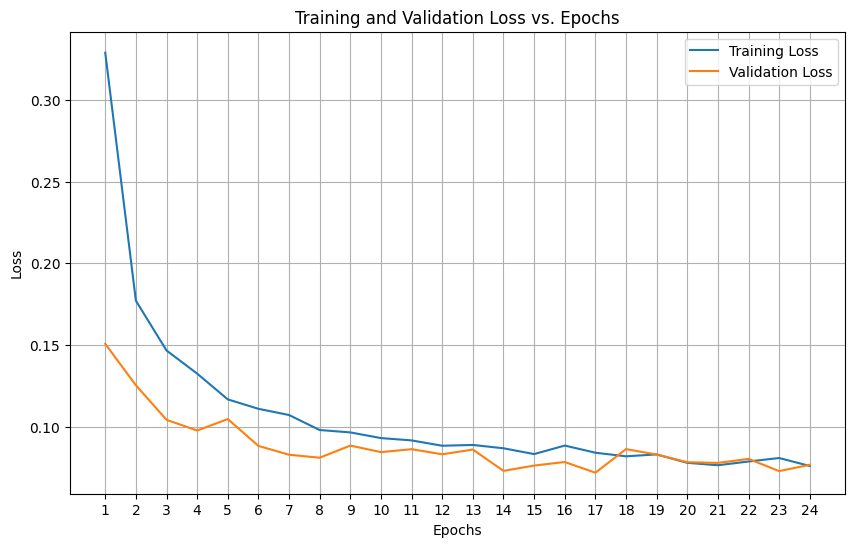

In [25]:
# --- 10. Plotting the Loss Curve ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, epoch + 1, 1))
plt.legend()
plt.grid(True)
plt.show()

# Suppress plot output if running in a non-interactive environment
try:
    plt.close()
except:
    pass

Successfully loaded best model weights from checkpoint.


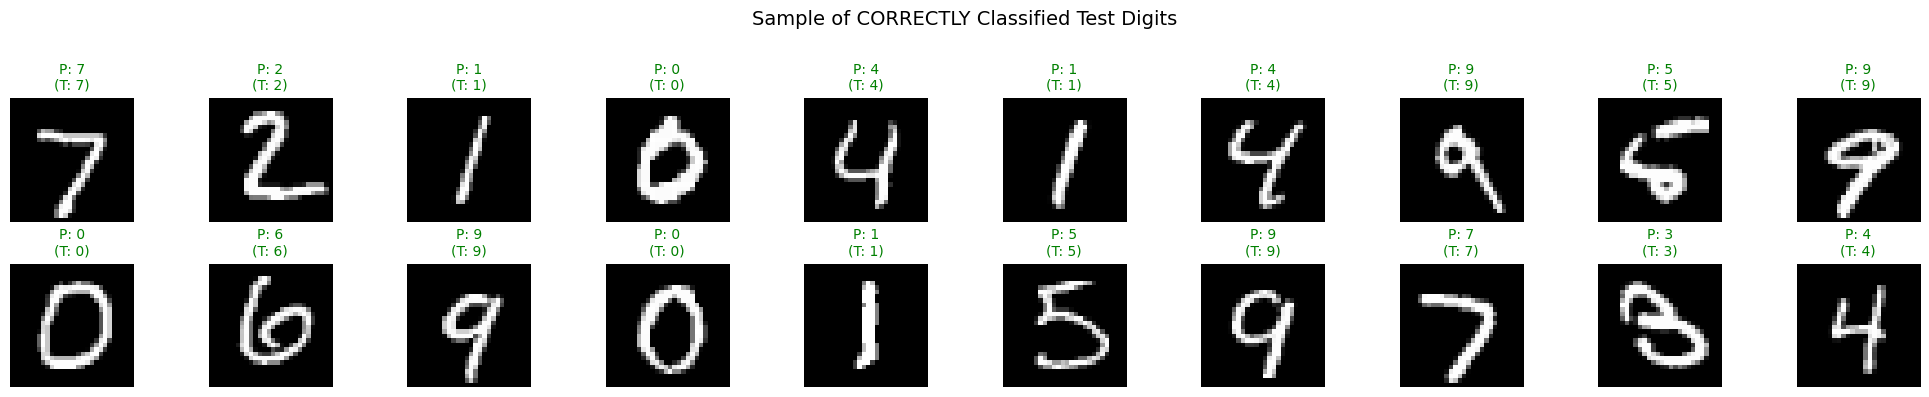


Total Misclassified Samples: 189 out of 10000


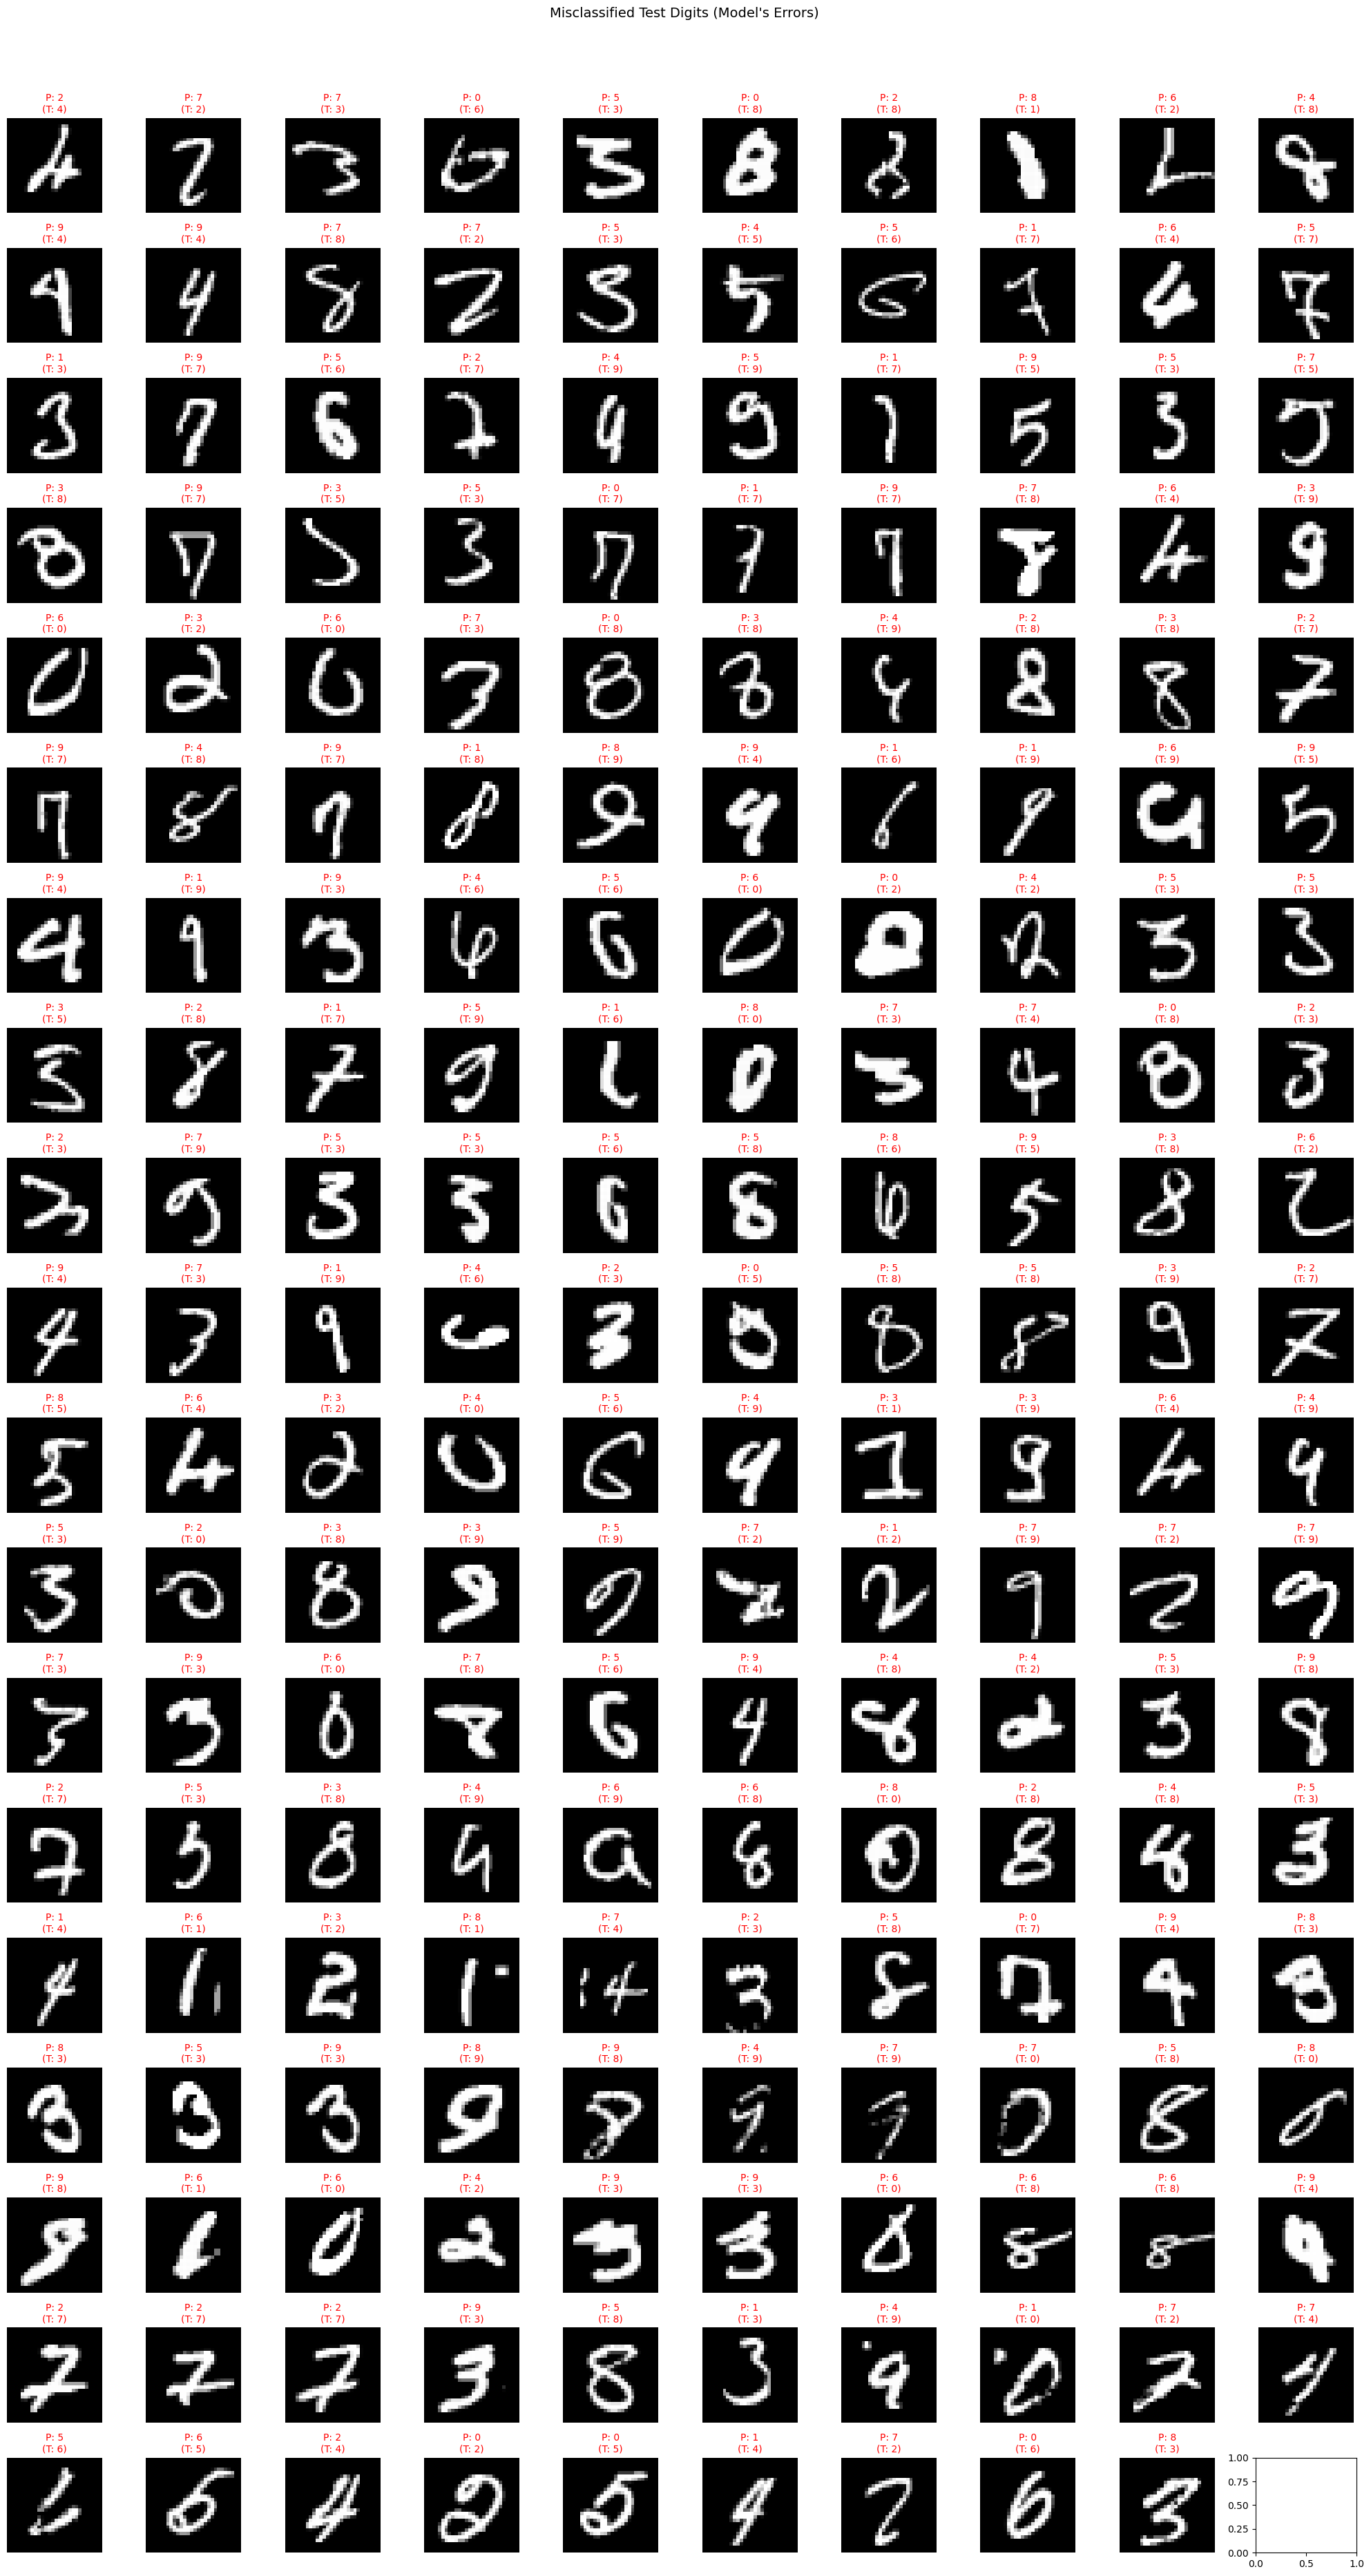

In [28]:
# ---1. Initialize and load the BEST model state
model = ANN(input_size, num_classes).to(device)
try:
    model.load_state_dict(torch.load('checkpoint_best_model.pt'))
    print("Successfully loaded best model weights from checkpoint.")
except FileNotFoundError:
    print("Error: 'checkpoint_best_model.pt' not found. Ensure training was run.")
    sys.exit()

# --- 2. Run Predictions and Collect Results ---
model.eval() # Set model to evaluation mode (disables dropout)

all_images = []
all_preds = []
all_targets = []
misclassified_indices = []
index = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Get the predicted class (index of the max log-probability)
        preds = output.argmax(dim=1)
        
        # Determine misclassifications
        incorrect_mask = (preds != target)
        
        # Collect data for visualization
        all_images.append(data.cpu())
        all_preds.append(preds.cpu())
        all_targets.append(target.cpu())

        # Collect indices of misclassified samples
        current_misclassified = torch.where(incorrect_mask)[0] + index
        misclassified_indices.extend(current_misclassified.tolist())
        
        index += data.size(0)

# Concatenate all lists into single tensors
all_images = torch.cat(all_images)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# --- 3. Visualization Function ---
def visualize_predictions(images, targets, preds, indices, title, rows=2, cols=10):
    
    # Calculate the number of items to display
    num_to_display = min(len(indices), rows * cols)
    display_indices = indices[:num_to_display]
    
    # Un-normalize the images for correct display (optional, but makes them clearer)
    # Reverse the transformation: x = x * std + mean
    inv_transform = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(display_indices):
        img = images[idx]
        img = inv_transform(img) # Un-normalize
        
        ax = axes[i]
        
        # Squeeze to remove channel dim: (1, 28, 28) -> (28, 28)
        ax.imshow(img.squeeze().numpy(), cmap='gray') 
        
        true_label = targets[idx].item()
        pred_label = preds[idx].item()
        
        # Highlight misclassified images in red
        color = 'red' if true_label != pred_label else 'green'
        
        ax.set_title(f"P: {pred_label}\n(T: {true_label})", color=color, fontsize=10)
        ax.axis('off')
        
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- 4. Display Results ---

# 4a. Display a sample of CORRECTLY classified digits
correctly_classified_indices = [i for i in range(len(all_images)) if i not in misclassified_indices]
visualize_predictions(
    all_images, all_targets, all_preds, 
    correctly_classified_indices, 
    "Sample of CORRECTLY Classified Test Digits", 
    rows=2, cols=10
)

# 4b. Display the misclassified digits (the model's errors)
print(f"\nTotal Misclassified Samples: {len(misclassified_indices)} out of {len(all_images)}")
visualize_predictions(
    all_images, all_targets, all_preds, 
    misclassified_indices, 
    "Misclassified Test Digits (Model's Errors)", 
    rows=19, cols=10 # Show more errors if available
)